In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout,ConvLSTM2D,Conv1D,MaxPooling1D, BatchNormalization, Activation
from keras.layers.embeddings import Embedding
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support
import itertools
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import os

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Data preprocessing

The original dataset consists of 23,486 reviews of womens clothing along with a 1 to 5 star rating. The first step of preparing the data was to drop all observations with no review comment resulting in 22,641 observations.

In [3]:
df = pd.read_csv('/Users/andreashaggstrom/Downloads/Data Science/Womens Clothing E-Commerce Reviews.csv')

In [4]:
df = df.dropna(subset=['Review Text'])

In [5]:
df[['Review Text', 'Rating']][0:10]

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5
5,"I love tracy reese dresses, but this one is no...",2
6,I aded this in my basket at hte last mintue to...,5
7,"I ordered this in carbon for store pick up, an...",4
8,I love this dress. i usually get an xs but it ...,5
9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5


The ratings are skewed towards the higher number of stars, which ofcourse is great for this retail company but may create concerns for the analysis. Giving a 5 stars rating means that you really enjoyed the product while if you give it a lower rating there might be something in the product not to like. To distinguish between if customers truly loved the product or found something not reaching their expectations I separate the observations into 5-star ratings as a group of comments with only positive sentiment and less than 5 stars into a group of less positive or negative sentiment. This gives an even distribution of positive sentiment = 1 and negative sentiment = 0.

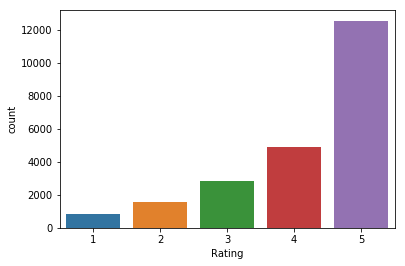

In [6]:
sns.countplot(df['Rating'])

In [7]:
df['Sentiment'] = df['Rating'].map(lambda x : 1 if int(x) > 4 else 0)

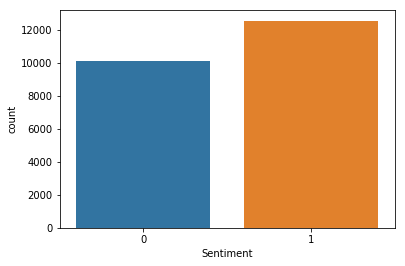

In [8]:
sns.countplot(df['Sentiment'])

The observations are then randomly split into a train and a test set. The test set is 20% of the observations. X is the review comments as text, y is the sentiment: 1: Positive, 0: Negative.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['Review Text'], df['Sentiment'], test_size=0.2)

The words in the comments are transformed into numbers, with a value for each unique word of the 10,000 most frequent words based on the training set. The texts are then compressed to a maximum length of 500 words and padded with zeros if the text is shorter than 500.

In [10]:
token = Tokenizer(num_words=10000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                  lower=True, split=' ', char_level=False, oov_token=None)

In [11]:
token.fit_on_texts(X_train)

In [12]:
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

In [13]:
X_train = pad_sequences(X_train,maxlen=500)
X_test = pad_sequences(X_test,maxlen=500)

The words are embedded according to Glove to group words with similar meanings and context.

In [14]:
word_index = token.word_index
embedding_dim = 100
max_sequence_length = 500

In [15]:
embeddings_index = {}
f = open(os.path.join('/Users/andreashaggstrom/Downloads/Data Science/glove', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [16]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [17]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)

## Model

The model is built with; the embedding layer; a recurrent layer with 128 LSTM units and 50% dropout to avoid overfitting and a final layer with a Sigmoid activation to predict the probability of a positive sentiment.

In [18]:
model = Sequential()

In [19]:
model.add(Embedding(input_dim=len(word_index) +1, output_dim=embedding_dim,
                    weights=[embedding_matrix], input_length=max_sequence_length,trainable=False
                       ))

In [20]:
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5))

In [21]:
model.add(Dense(1, activation='sigmoid'))

The model is compiled the Adam optimizer and binary crossentopy as the loss function. The training is evaluated on both loss and accuracy. 

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          1344800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,462,177
Trainable params: 117,377
Non-trainable params: 1,344,800
_________________________________________________________________


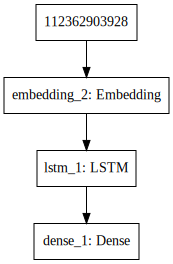

In [24]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

The model is trained for 40 epochs with a batch size of 64. 10% of the training set is used for evaluation.

In [25]:
history = model.fit(X_train, y_train, batch_size=64, epochs=40, validation_split=0.1)

Train on 16300 samples, validate on 1812 samples
Epoch 1/40
16300/16300 [==============================] - 242s 15ms/step - loss: 0.6610 - acc: 0.6006 - val_loss: 0.5951 - val_acc: 0.6882
Epoch 2/40
16300/16300 [==============================] - 242s 15ms/step - loss: 0.6264 - acc: 0.6510 - val_loss: 0.5746 - val_acc: 0.7141
Epoch 3/40
16300/16300 [==============================] - 246s 15ms/step - loss: 0.6016 - acc: 0.6734 - val_loss: 0.5512 - val_acc: 0.7246
Epoch 4/40
16300/16300 [==============================] - 257s 16ms/step - loss: 0.5798 - acc: 0.6953 - val_loss: 0.5336 - val_acc: 0.7439
Epoch 5/40
16300/16300 [==============================] - 254s 16ms/step - loss: 0.5571 - acc: 0.7158 - val_loss: 0.5120 - val_acc: 0.7561
Epoch 6/40
16300/16300 [==============================] - 245s 15ms/step - loss: 0.5455 - acc: 0.7269 - val_loss: 0.4916 - val_acc: 0.7787
Epoch 7/40
16300/16300 [==============================] - 247s 15ms/step - loss: 0.5298 - acc: 0.7395 - val_loss: 0.4

In [26]:
score = model.evaluate(X_test, y_test, batch_size=64)

4529/4529 [==============================] - 11s 2ms/step


The model converges smoothly towards an accuracy of 81% and a loss of 0.44.

In [27]:
print('Loss:' , round(score[0],2) , 'Accuracy:' , round(score[1],2))

Loss: 0.44 Accuracy: 0.81


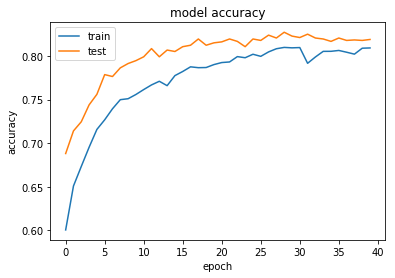

In [28]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

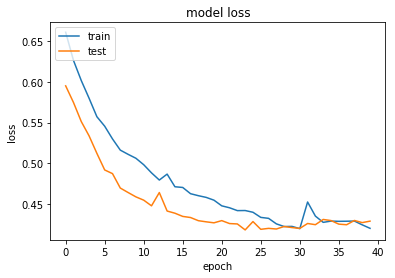

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Predictions and evaluation

The model is used to predict the sentiment based on the comments of the test set, which is data the model have not seen before. Predictions with probability over 50% are percieved as comments with positive sentiment. 

In [30]:
preds = model.predict(X_test, batch_size=64)

In [31]:
preds = (preds > 0.5)

The average f1 score based on the precision and recall is inline with the overall accuracy of 81%.

In [ ]:
print(precision_recall_fscore_support(y_test,preds))

In [32]:
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          0       0.85      0.72      0.77      2076
          1       0.79      0.89      0.83      2453

avg / total       0.81      0.81      0.81      4529



In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[1485  591]
 [ 272 2181]]


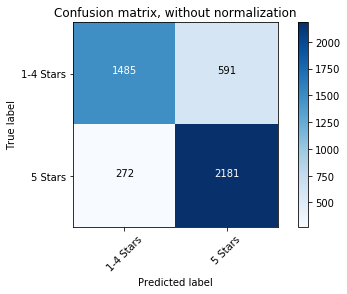

In [42]:
# Plot non-normalized confusion matrix

labels = ['1-4 Stars','5 Stars']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization')

A random forrest classifier is trained as a benchmark.

In [37]:
rfc = RandomForestClassifier(n_estimators=100)

In [38]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
rfc_pred = rfc.predict(X_test)

In [40]:
print(confusion_matrix(y_test,rfc_pred))

[[ 595 1481]
 [ 579 1874]]


In [41]:
print(classification_report(y_test,rfc_pred))

             precision    recall  f1-score   support

          0       0.51      0.29      0.37      2076
          1       0.56      0.76      0.65      2453

avg / total       0.53      0.55      0.52      4529



The recurrent neural network miss-classifies mainly false positives but get most of the true positives correct, it predicts the sentiment with a substantially higher precision and recall compared to the random forrest classifier.